In [1]:
# testing running multiple RCF on each target variable we want to detect anamolies on 

In [1]:
import boto3
import botocore
import sagemaker
import sys


bucket = (
    sagemaker.Session().default_bucket()
)  # Feel free to change to another bucket you have access to
prefix = "sagemaker/rcf-benchmarks"
execution_role = sagemaker.get_execution_role()
region = boto3.Session().region_name

# S3 bucket where the original data is downloaded and stored.
downloaded_data_bucket = f"explainable-ai-stall"
downloaded_data_prefix = "SimulatedData"


def check_bucket_permission(bucket):
    # check if the bucket exists
    permission = False
    try:
        boto3.Session().client("s3").head_bucket(Bucket=bucket)
    except botocore.exceptions.ParamValidationError as e:
        print(
            "Hey! You either forgot to specify your S3 bucket"
            " or you gave your bucket an invalid name!"
        )
    except botocore.exceptions.ClientError as e:
        if e.response["Error"]["Code"] == "403":
            print(f"Hey! You don't have permission to access the bucket, {bucket}.")
        elif e.response["Error"]["Code"] == "404":
            print(f"Hey! Your bucket, {bucket}, doesn't exist!")
        else:
            raise
    else:
        permission = True
    return permission


if check_bucket_permission(bucket):
    print(f"Training input/output will be stored in: s3://{bucket}/{prefix}")
if check_bucket_permission(downloaded_data_bucket):
    print(
        f"Downloaded training data will be read from s3://{downloaded_data_bucket}/{downloaded_data_prefix}"
    )

Training input/output will be stored in: s3://sagemaker-us-east-1-293556221747/sagemaker/rcf-benchmarks
Downloaded training data will be read from s3://explainable-ai-stall/SimulatedData


In [8]:
%%time

import pandas as pd

data_filename = "Stall_Data_71421.csv"
s3 = boto3.client("s3")
s3.download_file(downloaded_data_bucket, f"{downloaded_data_prefix}/{data_filename}", data_filename)
flight_data = pd.read_csv(data_filename, delimiter=",")

CPU times: user 68.4 ms, sys: 8.35 ms, total: 76.7 ms
Wall time: 225 ms


Before training any models it is important to inspect our data, first. Perhaps there are some underlying patterns or structures that we could provide as "hints" to the model or maybe there is some noise that we could pre-process away. The raw data looks like this:

In [9]:
flight_data.head()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_airspeed,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag
0,0,3,17933,842,9,177,10,20,-1.4397,264,...,264.000000,264.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1
1,1,3,17933,842,9,177,10,20,-1.4397,264,...,258.592229,261.296114,0.0,0.129163,0.064582,0.0,0.028621,0.014162,0.028621,1
2,2,3,17933,842,9,177,10,20,-1.4397,264,...,260.972284,261.188171,0.0,-0.442756,-0.104531,0.0,-0.097213,-0.022932,-0.097213,1
3,3,3,17933,842,9,177,10,20,-1.4397,264,...,265.193097,262.189402,0.0,0.786278,0.118171,0.0,0.169891,0.025826,0.169891,1
4,4,3,17933,842,9,177,10,20,-1.4397,264,...,253.983980,260.548318,0.0,-0.862286,-0.077920,0.0,-0.194536,-0.017136,-0.194536,1


In [10]:
flight_data.tail()

,Unnamed: 0,flight_id,initial_alt,time_to_buffet,time_from_buffet_to_uncommanded_descent,magnitude_of_uncommanded_descent,time_from_buffet_to_uncommanded_roll,magnitude_of_uncommanded_roll,period_of_uncommanded_roll,initial_airspeed,...,cur_airspeed,cur_avg_airspeed,roll,vertical_speed,cur_avg_vertical_speed,angle_of_attack,flight_path_angle,cur_avg_flight_path_angle,pitch_angle,sign_flag
10469,10469,3,17933,842,9,177,10,-10,-1.4397,264,...,0.0,0.0,-0.190809,-0.120383,-0.398199,21.0,0.0,0.0,21.0,1
10470,10470,3,17933,842,9,177,10,-9,-1.4397,264,...,0.0,0.0,-0.173648,-0.177469,-0.403300,21.0,0.0,0.0,21.0,1
10471,10471,3,17933,842,9,177,10,-8,-1.4397,264,...,0.0,0.0,-0.156434,-1.064795,-0.422756,21.0,0.0,0.0,21.0,1
10472,10472,3,17933,842,9,177,10,-7,-1.4397,264,...,0.0,0.0,-0.139173,-0.471731,-0.439159,21.0,0.0,0.0,21.0,1
10473,10473,3,17933,842,9,177,10,-6,-1.4397,264,...,0.0,0.0,-0.121869,-0.247305,-0.438790,21.0,0.0,0.0,21.0,1


Human beings are visual creatures so let's take a look at a plot of the data.

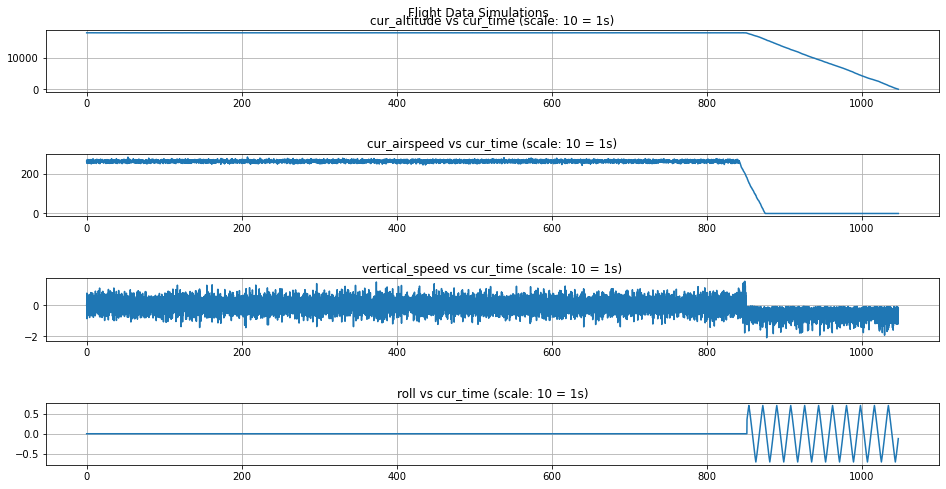

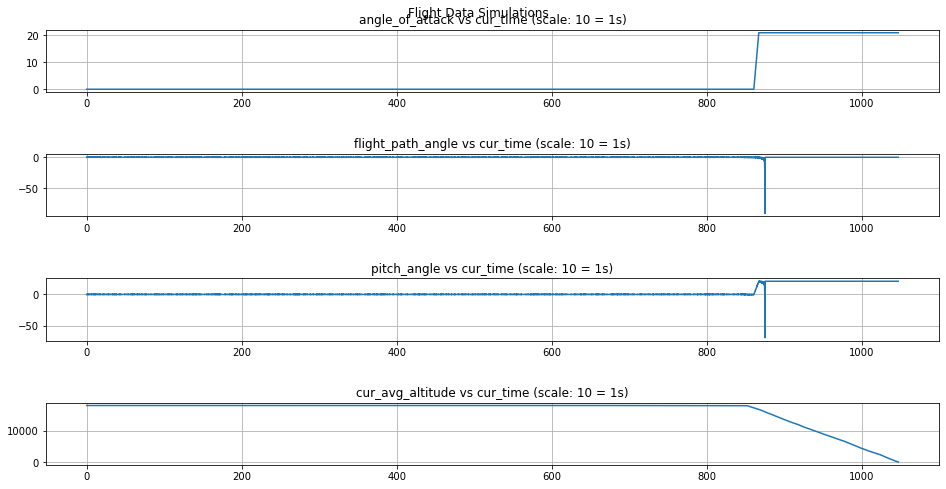

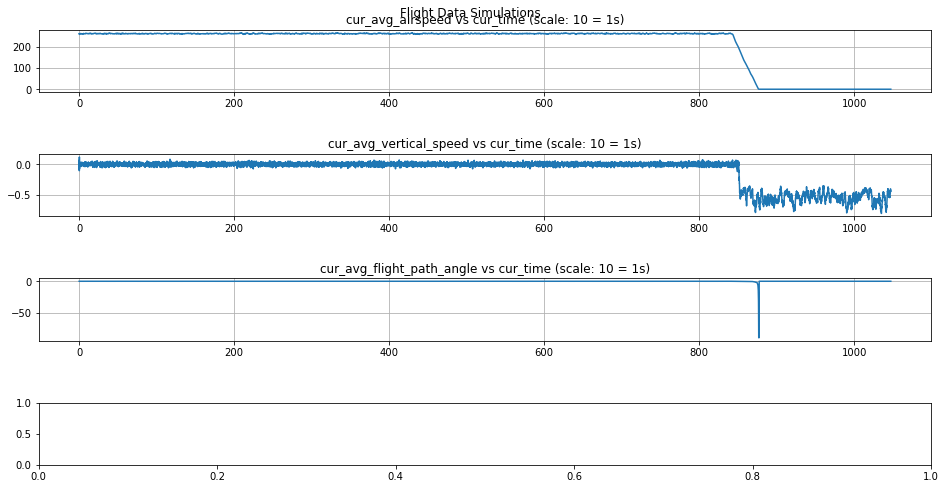

In [5]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt

# matplotlib.rcParams["figure.dpi"] = 100

# flight_data.plot("vertical_speed")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def lineplots_flight_data(cols, time, df, n):
    fig, axs = plt.subplots(nrows, 1, figsize=(16, 8))
    for col, ax in zip(cols, axs.flatten()):
        ax.grid()
        ax.plot(time, df[col])
        ax.set_title(col + ' vs ' + time.name + ' (scale: 10 = 1s)')
        #ax.set_xticks(np.arange(min(time), max(time) + 10, 10.0))
    plt.subplots_adjust(hspace=1, wspace=0.1)
    fig.suptitle('Flight Data Simulations', y=0.92)
#     fig.savefig(cwd + '/visuals/' + 'flight_data' + str(n) + '.png')
    plt.show()
    plt.close()


if __name__ == '__main__':
    df = flight_data
    cols = ['cur_altitude', 'cur_airspeed', 'vertical_speed', 'roll', 'angle_of_attack', 'flight_path_angle', 'pitch_angle',
            'cur_avg_altitude', 'cur_avg_airspeed', 'cur_avg_vertical_speed', 'cur_avg_flight_path_angle']
    time = df['cur_time']
    nrows = 4  # How many figures you want in a single plot
    # Using list comprehension (https://www.geeksforgeeks.org/break-list-chunks-size-n-python/) to break up cols list into chunks based on nrows
    split_cols = [cols[i * nrows:(i + 1) * nrows] for i in range((len(cols) + nrows - 1) // nrows)]
    for n in range(len(split_cols)):
        lineplots_flight_data(split_cols[n], time, df, n)

In [17]:
# Break dataset into individual variable parts
veritcal_speed = flight_data[["cur_time","cur_avg_vertical_speed"]]
# air_speed = flight_data[["cur_time","cur_airspeed"]]

## Hyperparameters

Particular to a SageMaker RCF training job are the following hyperparameters:

* **`num_samples_per_tree`** - the number randomly sampled data points sent to each tree. As a general rule, `1/num_samples_per_tree` should approximate the the estimated ratio of anomalies to normal points in the dataset.
* **`num_trees`** - the number of trees to create in the forest. Each tree learns a separate model from different samples of data. The full forest model uses the mean predicted anomaly score from each constituent tree.
* **`feature_dim`** - the dimension of each data point.

In [28]:
### https://sagemaker.readthedocs.io/en/stable/overview.html#sagemaker-automatic-model-tuning ###

from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix}/",
    output_path=f"s3://{bucket}/{prefix}/output",
    num_samples_per_tree=512,
    num_trees=200,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(veritcal_speed.to_numpy()))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-14 15:31:00 Starting - Starting the training job...
2021-07-14 15:31:24 Starting - Launching requested ML instancesProfilerReport-1626276660: InProgress
......
2021-07-14 15:32:24 Starting - Preparing the instances for training.........
2021-07-14 15:33:54 Downloading - Downloading input data
2021-07-14 15:33:54 Training - Downloading the training image.....Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 15:34:45 INFO 139967802009408] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'num_samples_per_tree': 256, 'num_trees': 100, 'force_dense': 'true', 'eval_metrics': ['accuracy', 'precision_recall_fscore'], 'epochs': 1, 'mini_batch_size': 1000, '_log_level': 'info', '_kvstore': 'dist_async', '_num_kv_servers': 'auto', '_num_gpus': 'auto', '_tuning_objective_metric': '', '_ftp_port': 8999}
[07/14/2021 15:34:45 INFO 139967802009408] Merging with provided


2021-07-14 15:34:59 Uploading - Uploading generated training model
2021-07-14 15:34:59 Completed - Training job completed
Training seconds: 78
Billable seconds: 78


In [30]:
print(f"Training job name: {rcf.latest_training_job.job_name}")

Training job name: randomcutforest-2021-07-14-15-31-00-381


# Inference

***

A trained Random Cut Forest model does nothing on its own. We now want to use the model we computed to perform inference on data. In this case, it means computing anomaly scores from input time series data points.

We create an inference endpoint using the SageMaker Python SDK `deploy()` function from the job we defined above. We specify the instance type where inference is computed as well as an initial number of instances to spin up. We recommend using the `ml.c5` instance type as it provides the fastest inference time at the lowest cost.

In [31]:
rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------!

In [32]:
print(f"Endpoint name: {rcf_inference.endpoint}")

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Endpoint name: randomcutforest-2021-07-14-15-35-35-796


Let's pass the training dataset, in CSV format, to the inference endpoint so we can automatically detect the anomalies we saw with our eyes in the plots, above.

In [34]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

# Vertical Speed
veritcal_speed_numpy = veritcal_speed.to_numpy()
print(veritcal_speed_numpy[:2])
results = rcf_inference.predict(
    veritcal_speed_numpy[:2], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)

# # Airspeed
# air_speed_numpy = air_speed.to_numpy()
# print(air_speed_numpy[:2])
# results = rcf_inference.predict(
#     air_speed_numpy[:2], initial_args={"ContentType": "text/csv", "Accept": "application/json"}
# )

[[0.         0.         5.58637337]
 [0.1        0.0645815  5.58633821]]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores for cur_avg_altitude, cur_avg_airspeed, cur_avg_vertical_speed, cur_avg_flight_path_angle, and roll.

In [36]:
results = rcf_inference.predict(veritcal_speed_numpy)
scores = [datum["score"] for datum in results["scores"]]
veritcal_speed["score"] = pd.Series(scores, index=veritcal_speed.index)
veritcal_speed.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,cur_time,cur_avg_vertical_speed,score
0,0.0,0.000000,5.606643
1,0.1,0.064582,5.606477
2,0.2,-0.104531,5.606285
3,0.3,0.118171,5.606097
4,0.4,-0.077920,5.604759


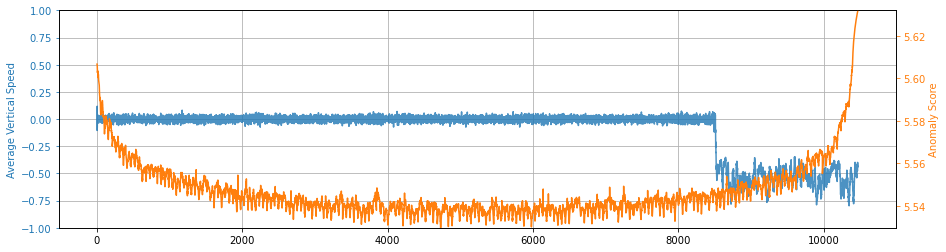

In [38]:
# cur_avg_vertical_speed, to find onset of uncommanded descent/stall 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 0, len(veritcal_speed)
flight_data_subset = veritcal_speed[start:end]
ax1.plot(flight_data_subset["cur_avg_vertical_speed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Average Vertical Speed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-1,1)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)

Note that the anomaly score spikes where our eyeball-norm method suggests there is an anomalous data point as well as in some places where our eyeballs are not as accurate.

Below we print and plot any data points with scores greater than 2 standard deviations (approx 95th percentile) from the mean score.

In [39]:
### Stopped here, doesnt seem to be working better ###

score_mean = flight_data["score"].mean()
score_std = flight_data["score"].std()
print(f"Mean of all Scores: ",score_mean)
print(f"Standard Deviation of all Scores: ",score_std)
score_cutoff = score_mean + 2 * score_std

anomalies = flight_data_subset[flight_data_subset["score"] > score_cutoff]
anomalies

KeyError: 'score'

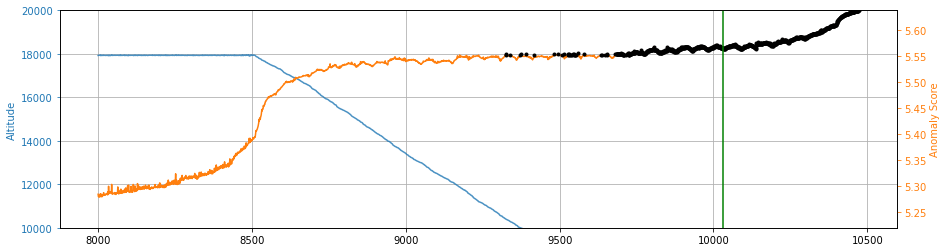

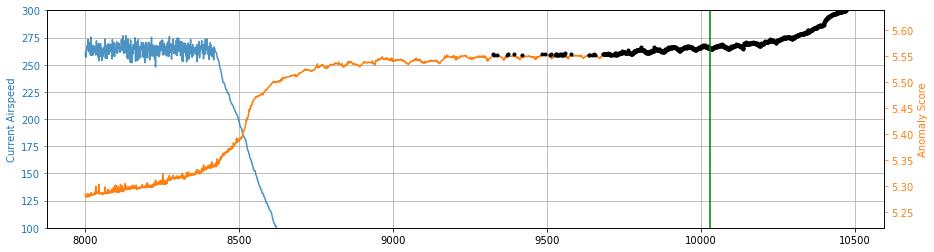

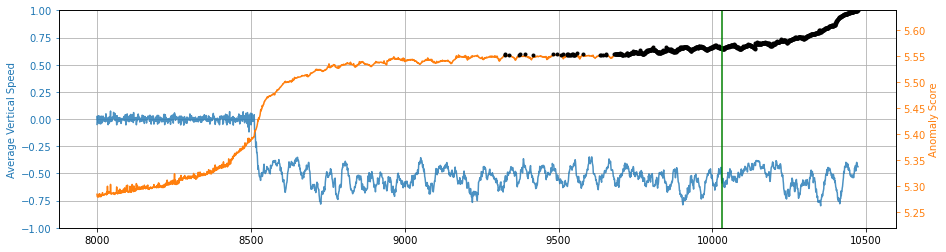

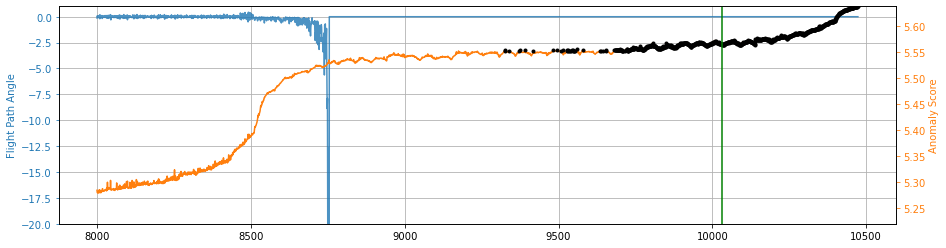

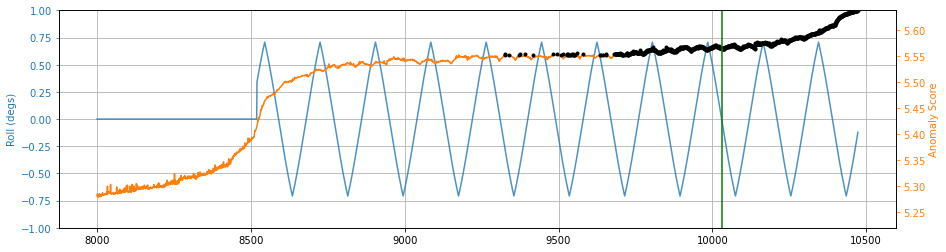

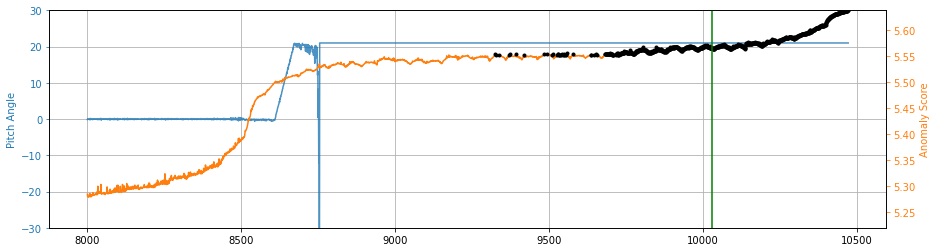

In [28]:
# cur_altitude, to find onset of uncommanded descent
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 8000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_altitude"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Altitude", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(10000,20000)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# cur_airspeed, to find onset of uncommanded descent/stall 
#### (as plane tries to accelorate to avoid stall?) ####
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 8000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_airspeed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Current Airspeed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(100,300)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# cur_avg_vertical_speed, to find onset of uncommanded descent/stall 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 8000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["cur_avg_vertical_speed"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Average Vertical Speed", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-1,1)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# flight_path_angle, stall indicator
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 8000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["flight_path_angle"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Flight Path Angle", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-20,1)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# roll, to find onset of uncommanded roll
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 8000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["roll"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Roll (degs)", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-1,1)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

# pitch_angle, to find onset of stall
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
start, end = 8000, len(flight_data)
flight_data_subset = flight_data[start:end]
ax1.plot(flight_data_subset["pitch_angle"], color="C0", alpha=0.8)
ax2.plot(flight_data_subset["score"], color="C1")
ax1.grid(which="major", axis="both")
ax1.set_ylabel("Pitch Angle", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(-30,30)
ax2.set_ylim(min(scores), max(scores))
fig.set_figwidth(15)
ax2.plot(anomalies.index, anomalies.score, "ko", markersize=3)
plt.axvline(x=10030, color='g', label='avline')

With the current hyperparameter choices we see that the two-standard-deviation threshold, while able to capture the known anomalies as well as the ones apparent in the ridership plot, is rather sensitive to fine-grained peruturbations and anomalous behavior. Adding trees to the SageMaker RCF model could smooth out the results as well as using a larger data set.

## Stop and Delete the Endpoint

Finally, we should delete the endpoint before we close the notebook.

To do so execute the cell below. Alternately, you can navigate to the "Endpoints" tab in the SageMaker console, select the endpoint with the name stored in the variable `endpoint_name`, and select "Delete" from the "Actions" dropdown menu. 

In [40]:
# What is the updatded code needed?
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Epilogue

---

We used Amazon SageMaker Random Cut Forest to detect anomalous datapoints in the flight dataset. In this data, the anomalies occurred when the dependant variables were uncharacteristically high or low. However, the RCF algorithm is also capable of detecting when, for example, data breaks periodicity or uncharacteristically changes global behavior.

There are several ways to improve algorithm performance. One method, for example, is to use an appropriate training set. If we know that a particular set of data is characteristic of "normal" flight behavior, then training on said set of data will more accurately characterize "abnormal" flight data.

Another improvement is make use of a windowing technique called "shingling". This is especially useful when working with periodic data with a known time period.. The idea is to treat a period of $P$ datapoints as a single datapoint of feature length $P$ and then run the RCF algorithm on these feature vectors. That is, if our original data consists of points $x_1, x_2, \ldots, x_N \in \mathbb{R}$ then we perform the transformation,

```
data = [[x_1],            shingled_data = [[x_1, x_2, ..., x_{P}],
        [x_2],    --->                     [x_2, x_3, ..., x_{P+1}],
        ...                                ...
        [x_N]]                             [x_{N-P}, ..., x_{N}]]

```

In [ ]:
import numpy as np


def shingle(data, shingle_size):
    num_data = len(data)
    shingled_data = np.zeros((num_data - shingle_size, shingle_size))

    for n in range(num_data - shingle_size):
        shingled_data[n] = data[n : (n + shingle_size)]
    return shingled_data


# single data with shingle size=48 (one day)
shingle_size = 48
prefix_shingled = "sagemaker/randomcutforest_shingled"
flight_data_shingled = shingle(flight_data.values[:, 1], shingle_size)
print(flight_data_shingled)

We create a new training job and and inference endpoint. (Note that we cannot re-use the endpoint created above because it was trained with one-dimensional data.)

In [ ]:
session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(
    role=execution_role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    data_location=f"s3://{bucket}/{prefix_shingled}/",
    output_path=f"s3://{bucket}/{prefix_shingled}/output",
    num_samples_per_tree=512,
    num_trees=50,
)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_shingled))

In [ ]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

rcf_inference = rcf.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

rcf_inference.serializer = CSVSerializer()
rcf_inference.deserializer = JSONDeserializer()

In [ ]:
print(rcf_inference.content_type, rcf_inference.accept)

Using the above inference endpoint we compute the anomaly scores associated with the shingled data.

In [ ]:
# Score the shingled datapoints
results = rcf_inference.predict(
    taxi_data_shingled, initial_args={"ContentType": "text/csv", "Accept": "application/json"}
)
scores = np.array([datum["score"] for datum in results["scores"]])

# compute the shingled score distribution and cutoff and determine anomalous scores
score_mean = scores.mean()
score_std = scores.std()
score_cutoff = score_mean + 3 * score_std

anomalies = scores[scores > score_cutoff]
anomaly_indices = np.arange(len(scores))[scores > score_cutoff]

print(anomalies)

Finally, we plot the scores from the shingled data on top of the original dataset and mark the score lying above the anomaly score threshold.

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data)
taxi_data_subset = taxi_data[start:end]

ax1.plot(taxi_data["value"], color="C0", alpha=0.8)
ax2.plot(scores, color="C1")
ax2.scatter(anomaly_indices, anomalies, color="k")

ax1.grid(which="major", axis="both")
ax1.set_ylabel("Taxi Ridership", color="C0")
ax2.set_ylabel("Anomaly Score", color="C1")
ax1.tick_params("y", colors="C0")
ax2.tick_params("y", colors="C1")
ax1.set_ylim(0, 40000)
ax2.set_ylim(min(scores), 1.4 * max(scores))
fig.set_figwidth(10)

We see that with this particular shingle size, hyperparameter selection, and anomaly cutoff threshold that the shingled approach more clearly captures the major anomalous events: the spike at around t=6000 and the dips at around t=9000 and t=10000. In general, the number of trees, sample size, and anomaly score cutoff are all parameters that a data scientist may need experiment with in order to achieve desired results. The use of a labeled test dataset allows the used to obtain common accuracy metrics for anomaly detection algorithms. For more information about Amazon SageMaker Random Cut Forest see the [AWS Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/randomcutforest.html).

In [ ]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)